In [3]:
import os
import sys
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from typing import Iterable, Tuple, List


# If the following line throws an error, do `pip install -e ./` from the base repo dir
from utils import ImageDataset

# Change to match data filepath on local
# base_fp = r'D:\Documents\MIDS\W281\2023-mids-w81-final-project-dataset\256x256'
base_fp = r'/Users/taehun.kim/mids/rendered_256x256/256x256'

In [4]:
# Load full dataset
full_dataset = ImageDataset.from_directory(base_fp)

NUM_CLASSES = full_dataset.num_classes
IMAGE_SIZE = full_dataset.image_size
assert IMAGE_SIZE == full_dataset[0].photos[0].load().shape, 'Photos and sketches are not the same size'

Loading dataset...
Loaded 12500 unique image IDs


In [28]:
SKETCH_ROOT = '/Users/taehun.kim/mids/rendered_256x256/256x256/sketch'

def get_tensorflow_dataset(ratios: List[float], augmentations: List[str] = None, seed: int = 1) -> List[tf.data.Dataset]:
    '''
    Get tensorflow dataset using generator to avoid RAM limitations
    Splits into train, val, test from all provided augmentations 
    '''

    # No augmentation by default
    augmentations = augmentations or ['tx_000000000000']

    assert sum(ratios) == 1 and len(ratios) == 3, 'Sum of 3 ratios must add to 1'

    datasets: List[Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]] = []
    for aug in augmentations:
        print(f'Reading images from augmentation {aug}...')
        train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
            directory = os.path.join(SKETCH_ROOT, aug),
            image_size = IMAGE_SIZE[:2],
            label_mode='categorical',
            seed = seed,
            color_mode = 'rgb',
            validation_split = (1 - ratios[0]),
            subset = 'both'
        )

        val_batch_count = int(tf.data.experimental.cardinality(val_ds))
        test_ds = val_ds.take(int(val_batch_count * ratios[1]))
        val_ds = val_ds.skip(int(val_batch_count * ratios[1]))

        datasets.append([train_ds, val_ds, test_ds])
    
    combined = datasets.pop()
    for train, val, test in datasets:
        combined[0] = combined[0].concatenate(train)
        combined[1] = combined[1].concatenate(val)
        combined[2] = combined[2].concatenate(test)

    return combined

In [30]:
train_ds, val_ds, test_ds = get_tensorflow_dataset([0.8, 0.1, 0.1], augmentations=['tx_000000000000', 'tx_000000000010'])

Reading images from augmentation tx_000000000000...
Found 75481 files belonging to 125 classes.
Using 60385 files for training.
Using 15096 files for validation.
Reading images from augmentation tx_000000000010...
Found 75481 files belonging to 125 classes.
Using 60385 files for training.
Using 15096 files for validation.


In [73]:
# Build model
pretrained_resnet = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=IMAGE_SIZE,
    pooling='avg',
    classes=NUM_CLASSES,
)
pretrained_resnet.trainable = False

layer = tf.keras.layers.Dense(1024, activation='relu')(pretrained_resnet.output)
layer = tf.keras.layers.Dense(512, activation='relu')(layer)
outputs = tf.keras.layers.Dense(len(train_ds.class_names), activation='softmax')(layer)
model = tf.keras.Model(pretrained_resnet.input, outputs)

In [75]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [76]:
# If below line isn't set, error is thrown regarding tf function decorator
tf.config.run_functions_eagerly(True)

# Reduce training size on non-powerful machines
reduce_training_size = True
actual_train_ds = train_ds.take(tf.data.experimental.cardinality(train_ds) // 100) if reduce_training_size else train_ds

epochs = 10
history = model.fit(
  actual_train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10


2023-04-08 14:42:12.392003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [60385]
	 [[{{node Placeholder/_0}}]]
2023-04-08 14:42:12.392796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [60385]
	 [[{{node Placeholder/_4}}]]


18/18 [==============================] - ETA: 0s - loss: 332.5832 - accuracy: 0.0104

2023-04-08 14:45:10.335517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [15096]
	 [[{{node Placeholder/_4}}]]
2023-04-08 14:45:10.335866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [15096]
	 [[{{node Placeholder/_4}}]]


18/18 [==============================] - 892s 52s/step - loss: 332.5832 - accuracy: 0.0104 - val_loss: 253.9557 - val_accuracy: 0.0057
Epoch 2/10
18/18 [==============================] - 808s 47s/step - loss: 146.3798 - accuracy: 0.0104 - val_loss: 63.7783 - val_accuracy: 0.0084
Epoch 3/10
18/18 [==============================] - 814s 47s/step - loss: 34.7183 - accuracy: 0.0069 - val_loss: 16.0081 - val_accuracy: 0.0126
Epoch 4/10
18/18 [==============================] - 801s 46s/step - loss: 9.3962 - accuracy: 0.0139 - val_loss: 5.7366 - val_accuracy: 0.0114
Epoch 5/10
18/18 [==============================] - 812s 47s/step - loss: 4.9863 - accuracy: 0.0104 - val_loss: 4.8791 - val_accuracy: 0.0119
Epoch 6/10
18/18 [==============================] - 767s 44s/step - loss: 4.7825 - accuracy: 0.0139 - val_loss: 4.8414 - val_accuracy: 0.0062
Epoch 7/10
18/18 [==============================] - 867s 50s/step - loss: 4.7943 - accuracy: 0.0087 - val_loss: 4.8493 - val_accuracy: 0.0106
Epoch 8/

In [79]:
def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    # Retrieve the training metrics (after each train epoch) and the final test accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    ax1.set_title('Accuracy')
    ax1.plot(train_accuracy, label='train_accuracy')
    ax1.plot(val_accuracy, label='validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.legend()

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    ax2.set_title('Loss')
    ax2.plot(train_loss, label='train loss')
    ax2.plot(val_loss, label='validation loss')
    ax2.set_xlabel('Epochs')
    ax2.legend()

    plt.show()

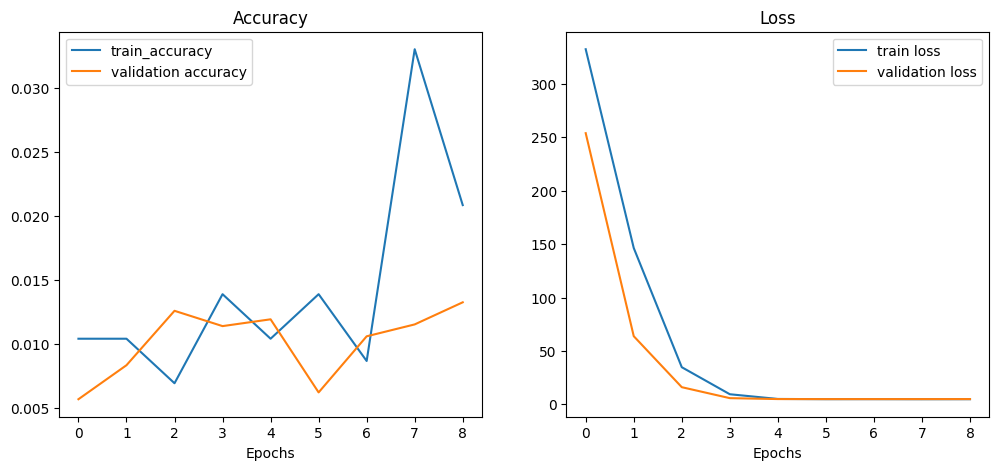

In [80]:
plot_results(history)